# ELFI-tutorial and assignments
## Probabilistic AI summerschool 2022

In this tutorial we go over the basics of model building and inference in likelihood-free setting using `elfi` - engine for likelihood-free inference. 

Other than `elfi`, there are other LFI software packages for (mainly) R and Python that you may wish to check out. Among them are e.g.
- `sbi`
- `abcpy`
- `pyabc`
- `DIYABC`

There's a [gitter-chatroom](https://gitter.im/elfi-dev/ELFI-workshops) named ELFI-workshops where you can copy-paste code and ask questions about the tutorial and the you'll be doing in the second part. 

First we need to install the package from PyPI

In [ ]:
!pip install -q --upgrade elfi

     |████████████████████████████████| 166 kB 5.5 MB/s 
     |████████████████████████████████| 959 kB 40.8 MB/s 
     |████████████████████████████████| 296 kB 40.1 MB/s 
     |████████████████████████████████| 1.1 MB 35.3 MB/s 
     |████████████████████████████████| 99 kB 7.7 MB/s 
     |████████████████████████████████| 596 kB 51.5 MB/s 
     |████████████████████████████████| 140 kB 51.5 MB/s 
     |████████████████████████████████| 837 kB 50.2 MB/s 
     |████████████████████████████████| 71 kB 7.7 MB/s 
     |████████████████████████████████| 189 kB 57.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.1.0 which is incompatible.


Next, load all the necessary packages for the tutorial and the assigments, and activate some `logging`.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

import elfi
from elfi.methods.post_processing import adjust_posterior
from elfi.model.extensions import ModelPrior
from elfi.methods.bo.acquisition import MaxVar
from elfi.methods.bo.acquisition import RandMaxVar
from elfi.methods.bo.acquisition import ExpIntVar

%matplotlib inline
%precision 2

import logging
logging.basicConfig(level=logging.INFO)

# Set an arbitrary global seed to keep the randomly generated quantities the same
seed = 16062023
np.random.seed(seed)



## Model building with ELFI: case MA(2) model

We start the tutorial by using the 2nd order moving average model MA(2)  as an example. MA(2) is a common model used in univariate time series analysis. Assuming zero mean it can be written as

$$
x_t = w_t + \theta_1 w_{t-1} + \theta_2 w_{t-2},
$$

where $\theta_1, \theta_2 \in \mathbb{R}$ and $(w_k)_{k\in \mathbb{Z}} \sim \mathsf{Normal}(0,1)$ represents an independent and identically distributed sequence of white noise.

In `elfi` the form of the simulators have few requirements and restrictions that we need to take into account. Let's look at the definition of `MA2`.

In [ ]:
def MA2(t1, t2, n_obs=100, batch_size=1, random_state=None):
    # Make inputs 2d arrays for numpy broadcasting with w
    t1 = np.asanyarray(t1).reshape((-1, 1))
    t2 = np.asanyarray(t2).reshape((-1, 1))
    random_state = random_state or np.random

    w = random_state.randn(batch_size, n_obs+2)  # i.i.d. sequence ~ N(0,1)
    x = w[:, 2:] + t1 * w[:, 1:-1] + t2 * w[:, :-2]
    return x

Above, `t1`, `t2`, and `n_obs` are the arguments specific to the MA2 process. The latter two, `batch_size` and `random_state` are ELFI specific keyword arguments. The `batch_size` argument tells how many simulations are needed. The `random_state` argument is for generating random quantities in your simulator. It is a `numpy.RandomState` object that has all the same methods as `numpy.random` module has. It is used for ensuring consistent results and handling random number generation in parallel settings.

We can test the function by evaluating it with some parameter values. 

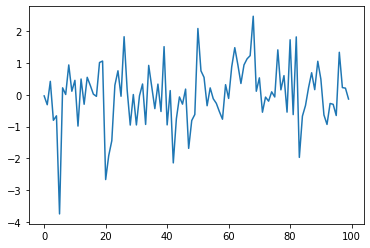

In [ ]:
t1 = 0.1
t2 = 0.3
xobs = MA2(t1, t2)
plt.plot(xobs.T);

Simulator is stochastic and the output will vary unless you fix the state in `numpy.RandomState`. Here's a few more realisations:

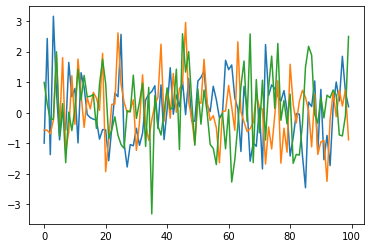

In [ ]:
plt.plot(MA2(t1, t2).T)
plt.plot(MA2(t1, t2).T)
plt.plot(MA2(t1, t2).T);

### Vectorization

What is the purpose of the `batch_size` argument? In ELFI, operations are vectorized, meaning that instead of simulating a single MA2 sequence at a time, we simulate a *batch* of them. A vectorized function takes vectors as inputs, and computes the output for each element in the vector. Vectorization is a way to make operations efficient in Python. 

In the MA2 simulator above we rely on numpy to carry out the vectorized calculations. The arguments `t1` and `t2` are going to be **vectors** of length `batch_size` and the function returns a 2D array of shape `(batch_size, n_obs)` with each row corresponding to a single argument pair. Notice that for convenience, the funtion also works with scalars as they are first converted to vectors.

There is a built-in tool (`elfi.tools.vectorize`) in ELFI to vectorize operations that are not vectorized. It is basically a `for` loop wrapper.


# Defining the model

ELFI includes a modeling syntax, where the generative model is specified as a directed acyclic graph ([DAG](https://en.wikipedia.org/wiki/Directed_acyclic_graph)). This provides an intuitive means to describe rather complex dependencies conveniently. Often the target of the generative model is a distance between the simulated and observed data. To start creating our model, we create an empty one, called... `model`

In [ ]:
model = elfi.new_model()

As discussed in the lectures, we need to define *prior* distributions for the unknown parameters $\theta_1, \theta_2$. In ELFI the priors can be any of the continuous and discrete distributions available in `scipy.stats` (we'll shortly have an example of custom priors). For simplicity, let's start by assuming that both parameters follow `Uniform(0, 2)`.

In [ ]:
# a node is defined by giving a distribution from scipy.stats together with any arguments (here 0 and 2)
elfi.Prior(ss.uniform, 0, 2, name='t1', model = model)

# some scipy.stats-distributions are accessible via keywords
elfi.Prior('uniform', 0, 2, name='t2', model = model);

Next, we define the *simulator* node for our model DAG with the `MA2` function, and give the priors to it as arguments. This means that the parameters for the simulations will be drawn from the priors. Because we have the observed data available for this node, we provide it here as well:

In [ ]:
elfi.Simulator(MA2, model['t1'], model['t2'], observed=xobs, name='MA2');

In model building stage, it if often convenient to check whether the end result looks like it's supposed to.

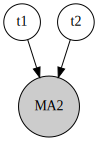

In [ ]:
elfi.draw(model)

You can test that the model is working by using `generate` method to draw random realisations of the graph.

{'MA2': array([[ 2.42,  3.1 ,  2.76,  1.35, -0.43,  2.16,  3.34,  1.88,  1.68,
         0.18,  2.3 ,  1.55,  2.  ,  0.61,  0.4 , -1.6 , -3.22, -1.32,
         2.84,  1.92,  0.54, -0.13,  3.24,  2.02,  0.64, -2.08, -0.2 ,
         2.12, -0.82, -2.05, -3.49,  1.57,  2.8 ,  0.49, -3.16, -1.71,
        -0.62, -2.05, -3.17, -2.11, -0.45,  0.09,  2.73,  1.05,  0.89,
        -0.59,  2.46,  1.85,  1.32, -0.39,  2.23,  0.34,  2.08, -1.2 ,
         0.03, -1.63,  0.75,  0.18,  1.43,  2.78,  2.94,  3.5 , -0.58,
        -1.13, -0.58,  4.6 ,  3.42,  2.31,  0.99,  1.18,  0.85, -0.19,
         1.99, -1.46, -1.52, -1.69,  1.1 ,  2.53,  0.12,  0.38,  0.62,
         1.89,  0.97,  0.05, -0.16, -2.09, -2.17, -0.38, -0.66,  1.56,
         0.52, -0.25, -0.06, -0.46,  1.36,  1.93,  3.68,  2.01,  0.49,
         1.07]]), 't2': array([1.45]), 't1': array([1.37])}


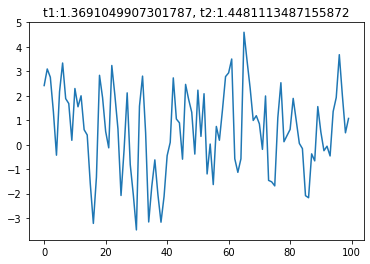

In [ ]:
model_output = model.generate(batch_size=1, outputs=['t1', 't2', 'MA2'])
print(model_output)
plt.plot(model_output['MA2'].T)
plt.title('t1:' + str(model_output['t1'][0]) + ', t2:' + str(model_output['t2'][0]));

But how does one compare the simulated sequences with the observed sequence? Looking at the plot of just a few observed sequences above, a direct pointwise comparison would probably not work very well: the three sequences look quite different although they were generated with the same parameter values. Indeed, the comparison of simulated sequences is often the most difficult (and ad hoc) part of ABC. Typically one chooses one or more summary statistics and then calculates the discrepancy between those.

Here, we will apply the intuition arising from the definition of the MA(2) process, and use the autocovariances with lags 1 and 2 as the summary statistics. Note that since the rows of `x` correspond to independent simulations, we have to tell this numpy function to take row-wise means by the keyword argument `axis=1`:

In [ ]:
def autocov(x, lag=1):
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1)
    return C

As is familiar by now, a `Summary` node is defined by giving the autocovariance function and the simulated data (which includes the observed as well):

In [ ]:
elfi.Summary(autocov, model['MA2'], name='S1')
elfi.Summary(autocov, model['MA2'], 2, name='S2');  # the optional keyword lag is given the value 2

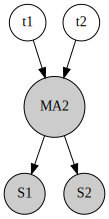

In [ ]:
elfi.draw(model)

We choose the discrepancy as the common Euclidean L2-distance. ELFI can use many common distances directly from `scipy.spatial.distance` like this:

In [ ]:
elfi.Distance('euclidean', model['S1'], model['S2'], name='d');

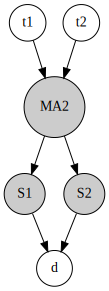

In [ ]:
elfi.draw(model)

# Modifying the model

Although the above definition is perfectly valid, let's use the same priors as in [*Marin et al. (2012)*](http://link.springer.com/article/10.1007/s11222-011-9288-2) that guarantee that the problem will be identifiable (loosely speaking, the likelihood willl have just one mode). Marin et al. used priors for which $-2<\theta_1<2$ with $\theta_1+\theta_2>-1$ and $\theta_1-\theta_2<1$ i.e. the parameters are sampled from a triangle (see below).

# Custom priors

In ELFI, custom distributions can be defined similar to distributions in `scipy.stats` (i.e. they need to have at least the `rvs` method implemented for the simplest algorithms). To be safe they can inherit `elfi.Distribution` which defines the methods needed. In this case we only need these for sampling, so implementing a static `rvs` method suffices. As was in the context of simulators, it is important to accept the keyword argument `random_state`, which is needed for ELFI's internal book-keeping of pseudo-random number generation. Also the `size` keyword is needed (which in the simple cases is the same as the `batch_size` in the simulator definition).

In [ ]:
# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class CustomPrior_t1(elfi.Distribution):
    def rvs(b, size=1, random_state=None):
        u = ss.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1

# define prior for t2 conditionally on t1 as in Marin et al., 2012, in range [-a, a]
class CustomPrior_t2(elfi.Distribution):
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = ss.uniform.rvs(loc=locs, scale=scales, size=size, random_state=random_state)
        return t2

These indeed define a uniform distribution on a triangle.

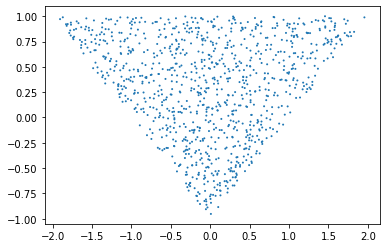

In [ ]:
t1_1000 = CustomPrior_t1.rvs(2, 1000)
t2_1000 = CustomPrior_t2.rvs(t1_1000, 1, 1000)
plt.scatter(t1_1000, t2_1000, s=4, edgecolor='none');

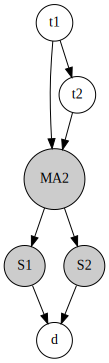

In [ ]:
model['t1'].become(elfi.Prior(CustomPrior_t1, 2))
model['t2'].become(elfi.Prior(CustomPrior_t2, model['t1'], 1))

elfi.draw(model)

# Rejection ABC

The simplest ABC algorithm samples parameters from their prior distributions, runs the simulator with these and compares them to the observations. The samples are either accepted or rejected depending on how large the distance is. The accepted samples represent samples from the approximate posterior distribution.

In ELFI, ABC methods are initialized either with a node giving the distance, or with the `ElfiModel` object and the name of the distance node. Depending on the inference method, additional arguments may be accepted or required. 

A common optional keyword argument, accepted by all inference methods, `batch_size` defines how many simulations are performed in each passing through the graph. 

Another optional keyword is the seed. This ensures that the outcome will be always the same for the same data and model. If you leave it out, a random seed will be taken.

In [ ]:
rej = elfi.Rejection(model['d'], batch_size=100, seed=seed)

In [ ]:
N = 1000
rejABC_posterior = rej.sample(N, threshold=0.2)

Progress [==================================================] 100.0% Complete


In [ ]:
rejABC_posterior.summary()

Method: Rejection
Number of samples: 1000
Number of simulations: 34200
Threshold: 0.2
Parameter                Mean               2.5%              97.5%
t1:                     0.108             -0.169              0.386
t2:                     0.224             -0.075              0.598



The `sample` method returns a `Sample` object, which contains several attributes and methods. Most notably the attribute `samples` contains an `OrderedDict` (i.e. an ordered Python dictionary) of the posterior numpy arrays for all the model parameters (`elfi.Prior`s in the model). For rejection sampling, other attributes include e.g. the `threshold`, which is the threshold value resulting in the requested quantile. 

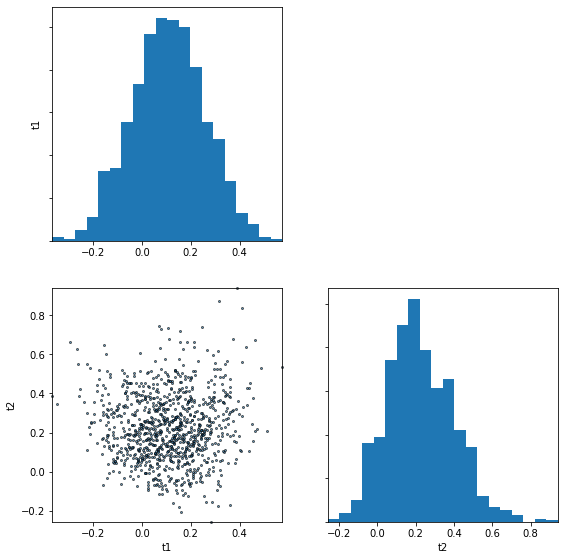

In [ ]:
rejABC_posterior.plot_pairs();

# Sequential Monte Carlo ABC

SMC-ABC sampler is initialised just like the Rejection sampler. Modelwise, a major difference is that the algorithm requires a prior pdf.

In [ ]:
# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class CustomPrior_t1(elfi.Distribution):
    def rvs(b, size=1, random_state=None):
        u = ss.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1
    
    def pdf(x, b):
        p = 1./b - np.abs(x) / (b*b)
        p = np.where(p < 0., 0., p)  # disallow values outside of [-b, b] (affects weights only)
        return p

    
# define prior for t2 conditionally on t1 as in Marin et al., 2012, in range [-a, a]
class CustomPrior_t2(elfi.Distribution):
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = ss.uniform.rvs(loc=locs, scale=scales, size=size, random_state=random_state)
        return t2
    
    def pdf(x, t1, a):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        p = ss.uniform.pdf(x, loc=locs, scale=scales)
        p = np.where(scales>0., p, 0.)  # disallow values outside of [-a, a] (affects weights only)
        return p
    
    
# Redefine the priors
model['t1'].become(elfi.Prior(CustomPrior_t1, 2, model=model))
model['t2'].become(elfi.Prior(CustomPrior_t2, model['t1'], 1))

In [ ]:
smc = elfi.SMC(model['d'], batch_size=100, seed=seed)

For SMC ABC, we have to define the number of output samples, the number of populations and a *schedule* i.e. a list of thresholds to use for each population. 

In [ ]:
N = 1000
thresholds = [0.7, 0.2, 0.05]
result_smc = smc.sample(N, thresholds, bar=False)

INFO:elfi.methods.inference.samplers:---------------- Starting round 0 ----------------
INFO:elfi.methods.inference.samplers:---------------- Starting round 1 ----------------
INFO:elfi.methods.inference.samplers:---------------- Starting round 2 ----------------


In [ ]:
result_smc.summary(all=True)

Method: SMC
Number of samples: 1000
Number of simulations: 94500
Threshold: 0.05
Parameter                Mean               2.5%              97.5%
t1:                     0.099             -0.107              0.325
t2:                     0.244              0.012              0.526


Population 0:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 2800
Threshold: 0.683
Parameter                Mean               2.5%              97.5%
t1:                     0.074             -0.572              0.707
t2:                     0.128             -0.493              0.888


Population 1:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 16500
Threshold: 0.2
Parameter                Mean               2.5%              97.5%
t1:                     0.094             -0.182              0.354
t2:                     0.235             -0.072              0.629


Population 2:
Method: Rejection within SMC-ABC
Number of samples: 1000

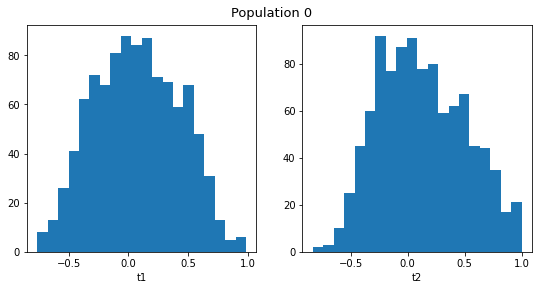

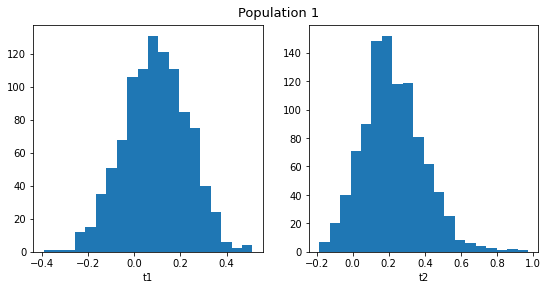

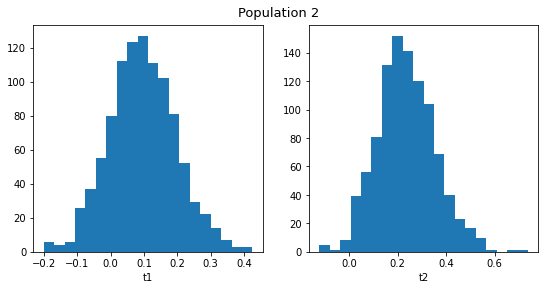

In [ ]:
result_smc.plot_marginals(all=True)

In the end `SMC` required 94500 samples to obtain 1000 samples below threshold = 0.05. Let's run rejection ABC until we have 1000 samples below threshold 0.05:

In [ ]:
N = 1000
rejABC_posterior = rej.sample(N, threshold=0.05)

In [ ]:
rejABC_posterior.summary()

Method: Rejection
Number of samples: 1000
Number of simulations: 503600
Threshold: 0.05
Parameter                Mean               2.5%              97.5%
t1:                     0.100             -0.131              0.355
t2:                     0.243              0.002              0.517



# BOLFI 

In practice inference problems often have a complicated and computationally heavy simulator, and one simply cannot run it for millions of times. The Bayesian Optimization for Likelihood-Free Inference [BOLFI](http://jmlr.csail.mit.edu/papers/v17/15-017.html) framework is likely to prove useful in such situation: a statistical model (usually [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process), GP) is created for the discrepancy, and its minimum is inferred with [Bayesian optimization](https://en.wikipedia.org/wiki/Bayesian_optimization). This approach typically reduces the number of required simulator calls by several orders of magnitude.

This tutorial demonstrates how to use BOLFI to do LFI in ELFI.

# Fitting the surrogate model

Now we can immediately proceed with the inference. However, when dealing with a Gaussian process, it may be beneficial to take a logarithm of the discrepancies in order to reduce the effect that high discrepancies have on the GP. (Sometimes you may want to add a small constant to avoid very negative or even -Inf distances occurring especially if it is likely that there can be exact matches between simulated and observed data.) In ELFI such transformed node can be created easily:

In [ ]:
elfi.Operation(np.log, model['d'], name='log_d');

Operation(name='log_d')

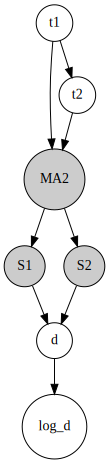

In [ ]:
elfi.draw(model)

As BOLFI is a more advanced inference method, its interface is also a bit more involved as compared to for example rejection sampling. But not much: Using the same graphical model as earlier, the inference could begin by defining a Gaussian process (GP) model, for which ELFI uses the [GPy](https://sheffieldml.github.io/GPy/) library. This could be given as an `elfi.GPyRegression` object via the keyword argument `target_model`. In this case, we are happy with the default that ELFI creates for us when we just give it each parameter some `bounds` as a dictionary.

Other notable arguments include the `initial_evidence`, which gives the number of initialization points sampled straight from the priors before starting to optimize the acquisition of points, `update_interval` which defines how often the GP hyperparameters are optimized, and `acq_noise_var` which defines the diagonal covariance of noise added to the acquired points. Note that in general BOLFI does not benefit from a `batch_size` higher than one, since the acquisition surface is updated after each batch (especially so if the noise is 0!).

In [ ]:
bolfi = elfi.BOLFI(model['log_d'], batch_size=1, initial_evidence=20, update_interval=10, 
                   bounds={'t1':(-2, 2), 't2':(-1, 1)}, acq_noise_var={'t1':0.1, 't2':0.1}, seed=seed)

Sometimes you may have some samples readily available. You could then initialize the GP model with a dictionary of previous results by giving `initial_evidence=result.outputs`.

The BOLFI class can now try to `fit` the surrogate model (the GP) to the relationship between parameter values and the resulting discrepancies. We'll request only 100 evidence points (including the `initial_evidence` defined above).

In [ ]:
post = bolfi.fit(n_evidence=100)

INFO:elfi.methods.inference.bolfi:BOLFI: Fitting the surrogate model...


Progress [==================================================] 100.0% Complete


INFO:elfi.methods.posteriors:Using optimized minimum value (-1.6062) of the GP discrepancy mean function as a threshold


In [ ]:
bolfi.target_model


Name : GP regression
Objective : 78.53641077165285
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |     priors    
  sum.rbf.variance         |   0.3630657802137458  |      +ve      |  Ga(0.0083, 1)
  sum.rbf.lengthscale      |  0.48910102787502585  |      +ve      |   Ga(1.3, 1)  
  sum.bias.variance        |  0.03436487581949289  |      +ve      |  Ga(0.0021, 1)
  Gaussian_noise.variance  |  0.12611712861991034  |      +ve      |               

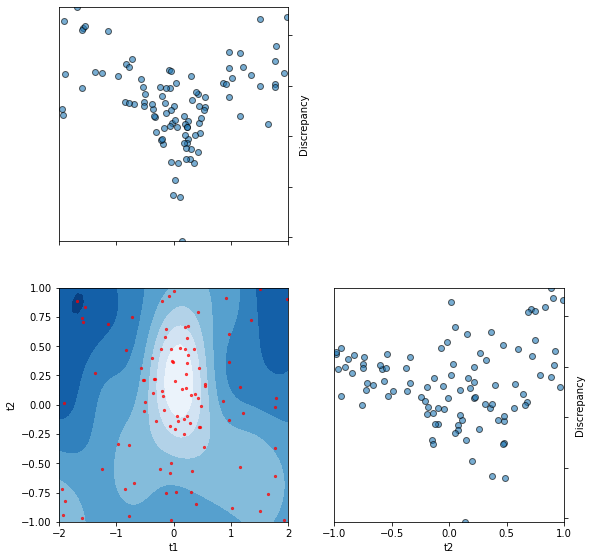

In [ ]:
bolfi.plot_gp();

INFO:elfi.methods.inference.bolfi:BOLFI: Fitting the surrogate model...


Progress [==================================================] 100.0% Complete


INFO:elfi.methods.posteriors:Using optimized minimum value (-1.7532) of the GP discrepancy mean function as a threshold


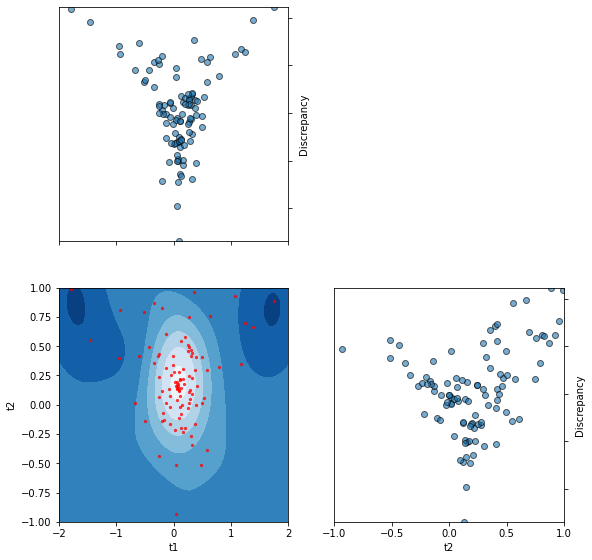

In [ ]:
gp = elfi.GPyRegression(model.parameter_names, bounds={'t1':(-2, 2), 't2': (-1, 1)})
prior = ModelPrior(model)

acq = MaxVar(model = gp, prior = prior)

bolfi = elfi.BOLFI(model['log_d'],
                   batch_size = 1,
                   initial_evidence = 20,
                   update_interval = 1,
                   target_model = gp,
                   acquisition_method = acq
                   )

bolfi.fit(100)
bolfi.plot_gp();

INFO:elfi.methods.inference.bolfi:BOLFI: Fitting the surrogate model...


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.080
INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.380


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.380


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.480


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.240


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.420


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.380


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.340


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.400


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.440


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.460


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.400


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.380


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.400


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.440


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.440


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.400


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.460


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.060


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.360


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.440
INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.300


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.480


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.520


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.500


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.320


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.360


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.260
INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.300


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.220


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.220


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.220


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.280


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.120


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.280


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.280


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.280


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.260


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.260


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.260


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.180


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.260


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.220


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.280


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.280


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.280


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.300


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.280


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.340


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.380


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.120


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.240


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.360


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.320


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.320


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.320


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.320


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.280


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.280


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.320


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.060


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.380


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.220


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.240


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.300
INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.160


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.280


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.200


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.240


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.340


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.280


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.000


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.340


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.200


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.260


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.240


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.300


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.280


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.280


INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.320


Progress [==================================================] 100.0% Complete


INFO:elfi.methods.posteriors:Using optimized minimum value (-1.9308) of the GP discrepancy mean function as a threshold


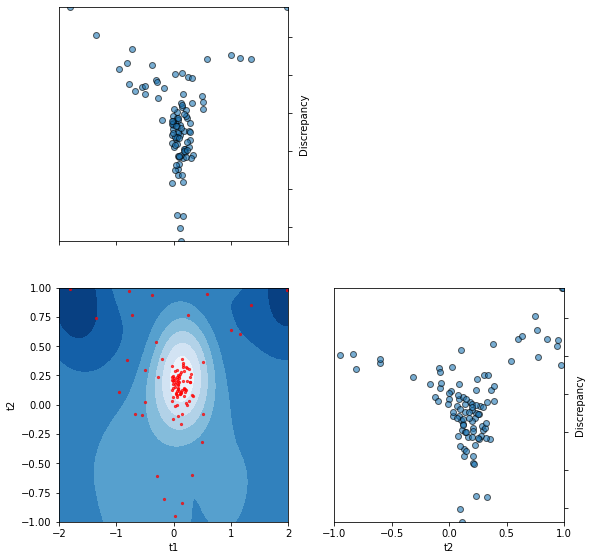

In [ ]:
gp = elfi.GPyRegression(model.parameter_names, bounds={'t1':(-2, 2), 't2': (-1, 1)})
prior = ModelPrior(model)

acq = RandMaxVar(model = gp,
                 prior = prior,
                 sampler='metropolis',
                 sigma_proposals={'t1': 4 / 10, 't2': 2/10})

bolfi = elfi.BOLFI(model['log_d'],
                   batch_size = 1,
                   initial_evidence = 20,
                   update_interval = 1,
                   target_model = gp,
                   acquisition_method = acq
                   )

bolfi.fit(100)
bolfi.plot_gp();

INFO:elfi.methods.inference.bolfi:BOLFI: Fitting the surrogate model...


 /usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning:divide by zero encountered in true_divide
 /usr/local/lib/python3.7/dist-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /usr/local/lib/python3.7/dist-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /usr/local/lib/python3.7/dist-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Progress [==================================================] 100.0% Complete


INFO:elfi.methods.posteriors:Using optimized minimum value (-1.8637) of the GP discrepancy mean function as a threshold


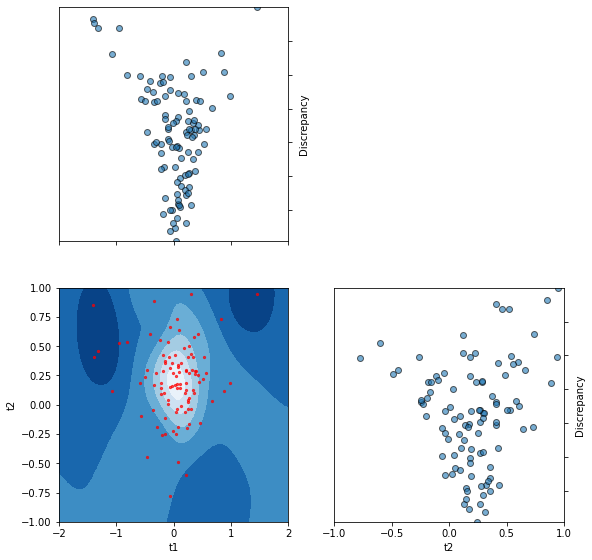

In [ ]:
gp = elfi.GPyRegression(model.parameter_names, bounds={'t1':(-2, 2), 't2': (-1, 1)})
prior = ModelPrior(model)

acq = ExpIntVar(model = gp,
                prior = prior,
                sampler='metropolis',
                sigma_proposals={'t1': 4 / 10, 't2': 2 / 10})

bolfi = elfi.BOLFI(model['log_d'],
                   batch_size = 1,
                   initial_evidence = 20,
                   update_interval = 1,
                   target_model = gp,
                   acquisition_method = acq
                   )

bolfi.fit(100)
bolfi.plot_gp();

# Sampling from the posterior surrogate

Finally, samples from the posterior can be acquired with an MCMC sampler. By default it runs 4 chains, and half of the requested samples are spent in adaptation/warmup. Note that depending on the smoothness of the GP approximation, the number of priors, their gradients etc., **the default sampler may be slow**.

In [ ]:
BOLFI_posterior = bolfi.sample(200, info_freq=100)

INFO:elfi.methods.posteriors:Using optimized minimum value (-1.8637) of the GP discrepancy mean function as a threshold
INFO:elfi.methods.mcmc:NUTS: Performing 200 iterations with 100 adaptation steps.
INFO:elfi.methods.mcmc:NUTS: Iterations performed: 100/200...
INFO:elfi.methods.mcmc:NUTS: Adaptation/warmup finished. Sampling...
INFO:elfi.methods.mcmc:NUTS: Acceptance ratio: 0.431. After warmup 4 proposals were outside of the region allowed by priors and rejected, decreasing acceptance ratio.
INFO:elfi.methods.mcmc:NUTS: Performing 200 iterations with 100 adaptation steps.
INFO:elfi.methods.mcmc:NUTS: Iterations performed: 100/200...
INFO:elfi.methods.mcmc:NUTS: Adaptation/warmup finished. Sampling...
INFO:elfi.methods.mcmc:NUTS: Acceptance ratio: 0.377. After warmup 3 proposals were outside of the region allowed by priors and rejected, decreasing acceptance ratio.
INFO:elfi.methods.mcmc:NUTS: Performing 200 iterations with 100 adaptation steps.
INFO:elfi.methods.mcmc:NUTS: Iteration

4 chains of 200 iterations acquired. Effective sample size and Rhat for each parameter:
t1 468.46550943959176 1.00682048837027
t2 495.36243962449896 0.9988746763107251


In [ ]:
BOLFI_posterior.summary()

Method: BOLFI
Number of samples: 400
Number of simulations: 100
Threshold: -1.86
Parameter                Mean               2.5%              97.5%
t1:                     0.040             -0.236              0.317
t2:                     0.198             -0.084              0.500



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0413ad590>,
      dtype=object)

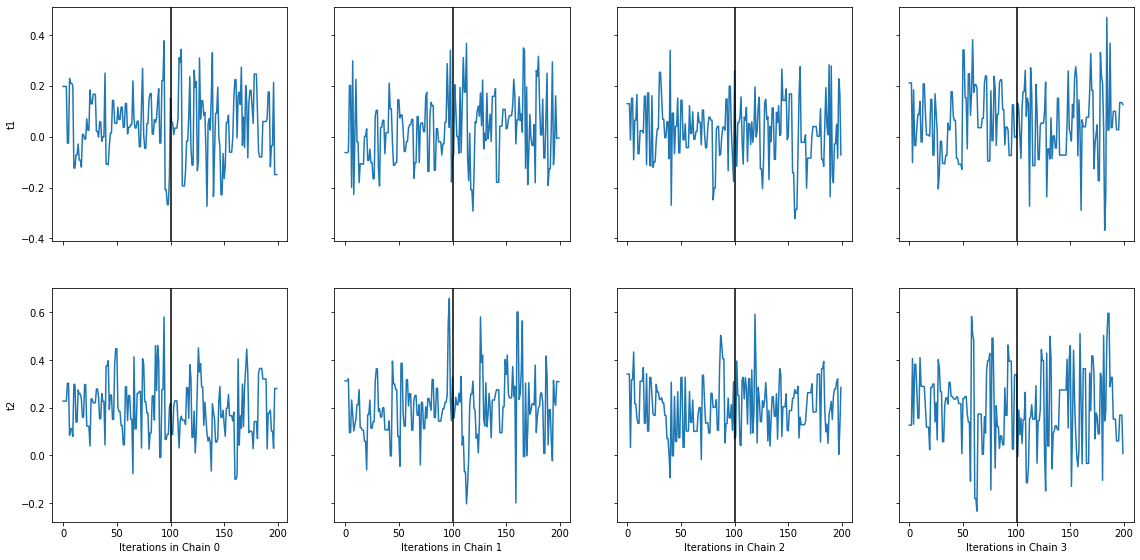

In [ ]:
BOLFI_posterior.plot_traces();

Instead of `nuts` sampler, we can also utilise simple `metropolis` mcmc-sampler which is often sufficient for small-scale problems. 

In [ ]:
BOLFI_posterior = bolfi.sample(2000, algorithm='metropolis', sigma_proposals={'t1': 4 / 10, 't2': 2 / 10})

INFO:elfi.methods.posteriors:Using optimized minimum value (-1.8637) of the GP discrepancy mean function as a threshold
INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.269
INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.267
INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.267
INFO:elfi.methods.mcmc:elfi.methods.mcmc: Total acceptance ratio: 0.256


4 chains of 2000 iterations acquired. Effective sample size and Rhat for each parameter:
t1 1108.3714284055893 1.0044533953223462
t2 660.2994743601151 1.0065897137304802


Method: BOLFI
Number of samples: 4000
Number of simulations: 100
Threshold: -1.86
Parameter                Mean               2.5%              97.5%
t1:                     0.063             -0.200              0.342
t2:                     0.182             -0.038              0.445



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0438e2290>,
      dtype=object)

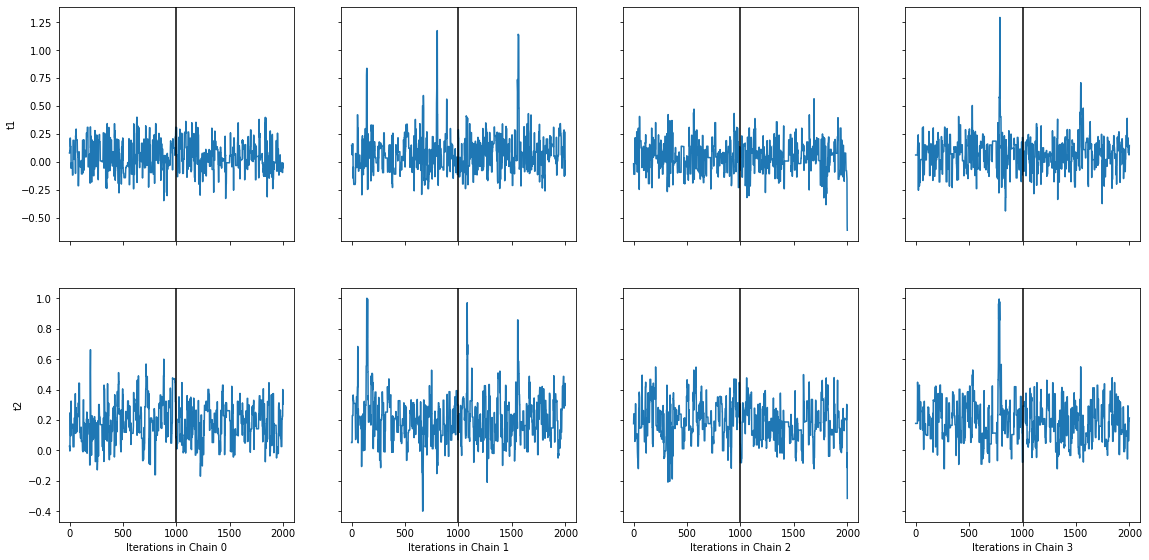

In [ ]:
BOLFI_posterior.summary()
BOLFI_posterior.plot_traces();

# Assignment 

We model a first-come-first-serve single server queue model (M/G/1 : Memoryless/General/Single server) and infer it's three parameters $\theta_1$, $\theta_2$ and $\theta_3$. 

In the model, the customer service times $U_n$ are uniformly distributed in the interval $[\theta_1, \theta_2]$ and arrival times $W_n$ between customers are exponentially distributed with rate $\theta_3$. 

Start simulation with an empty queue and assume that the simulator output (observed data) are the customer departure times $y_1, \ldots, y_{50}$, defined as
$$y_n = U_n, \quad \text{if} \quad \sum_{i=1}^n W_i \leq \sum_{i=1}^{n-1}Y_i$$  
$$ y_n = U_n + \sum_{i=1}^n W_i - \sum_{i=1}^{n-1}Y_i, \quad \text{otherwise} $$

The priors can be set as 
$$\theta_1 \thicksim \mathsf{Uniform}(0,10) \\ \theta_2 - \theta_1 \thicksim \mathsf{Uniform}(0, 10) \\ \theta_3 \thicksim \mathsf{Uniform}(0, 0.5)$$

Use e.g. $0-$, $0.25-$, $0.5-$, $0.75-$ and $1-$quantiles as summary statistics and euclidean distance. 

Use the following observed data: 



In [ ]:
xobs = np.array([[ 7.53,  9.99,  2.72,  2.28, 10.14,  8.95,  1.89,  6.16, 20.78,
                   15.1 ,  3.05,  1.86,  1.09,  4.3 ,  3.08,  2.13,  4.78,  3.62,
                   1.74,  4.48,  4.71,  1.05,  1.72,  3.36,  1.02,  1.86,  4.99,
                   3.86,  3.25, 29.54, 28.94,  2.8 ,  2.67,  4.55,  1.07,  4.32,
                   1.06,  1.52,  3.93,  3.86,  3.32,  2.07,  1.83,  6.26,  2.81,
                   1.56,  2.44,  2.68,  4.83,  4.24]])

# Tasks
# 1) Implement the model as ELFI-graph
# 2) Infer the parameters using 
## - Rejection ABC
## - SMC-ABC
## - BOLFI using MaxVar -acquisition
# 3) Plot the results